3. Group Proposed Project (10 marks)
3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on
it.
3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).

In [5]:
CLUSTER_COUNT = 50

In [6]:
import requests
import csv
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math

In [7]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Convert to datetime iso
def toIso(dt):
    return datetime.fromisoformat(dt)


def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(
            f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file):  # check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir, is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year, '/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
        # create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file
        df = pd.read_json(fDir)
        for heading in ("total_lots", "lot_type", "lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])

        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df

    def api_call_to_json(year, month, day, hour, minute, second):
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        return response_API, data

    fail_count = 0
    max_time_diff, time_diff = 25, 0
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)

    while not is_file_local and time_diff <= max_time_diff and fail_count < error_count:  # If file doesn't exist, api call
        new_min = str(int(minute) + time_diff)
        response_API, data = api_call_to_json(
            year, month, day, hour, new_min, new_min)

        # check if response is valid
        if response_API.ok and "items" in data and len(data["items"]) > 0 and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
            break
        elif time_diff < max_time_diff:
            time_diff += 1
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)
        else:
            fail_count += 1
            time_diff = 0
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)

    df = read_from_file(fDir)
    return df


# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"]


def addDayHour(df, day, hour):
    df["day"] = day
    df["hour"] = hour
    return df


def removeCountTotal(df):
    df = df.drop(columns=['lots_available', 'total_lots'])
    return df


In [8]:
carpark_rates_dir = f'./data/hdb-carpark-information.csv'
coord_df = pd.read_csv(carpark_rates_dir) 
coord_df[["car_park_no","x_coord","y_coord"]]

,car_park_no,x_coord,y_coord
0,ACB,30314.7936,31490.4942
1,ACM,33758.4143,33695.5198
2,AH1,29257.7203,34500.3599
3,AK19,28185.4359,39012.6664
4,AK31,29482.0290,38684.1754
...,...,...,...
2177,Y77M,29850.1522,45576.0125
2178,Y78M,30057.2209,45166.4820
2179,Y8,27772.9219,45686.2734
2180,Y82M,29935.5818,45679.7181


In [9]:
carparks = set()
location = dict()
for index,row in coord_df[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

2182 2182


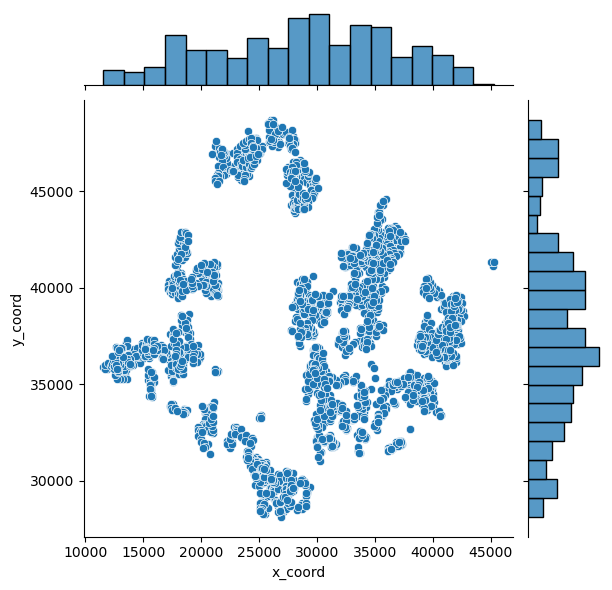

In [10]:
sns.jointplot(data=coord_df,x='x_coord',y='y_coord')

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

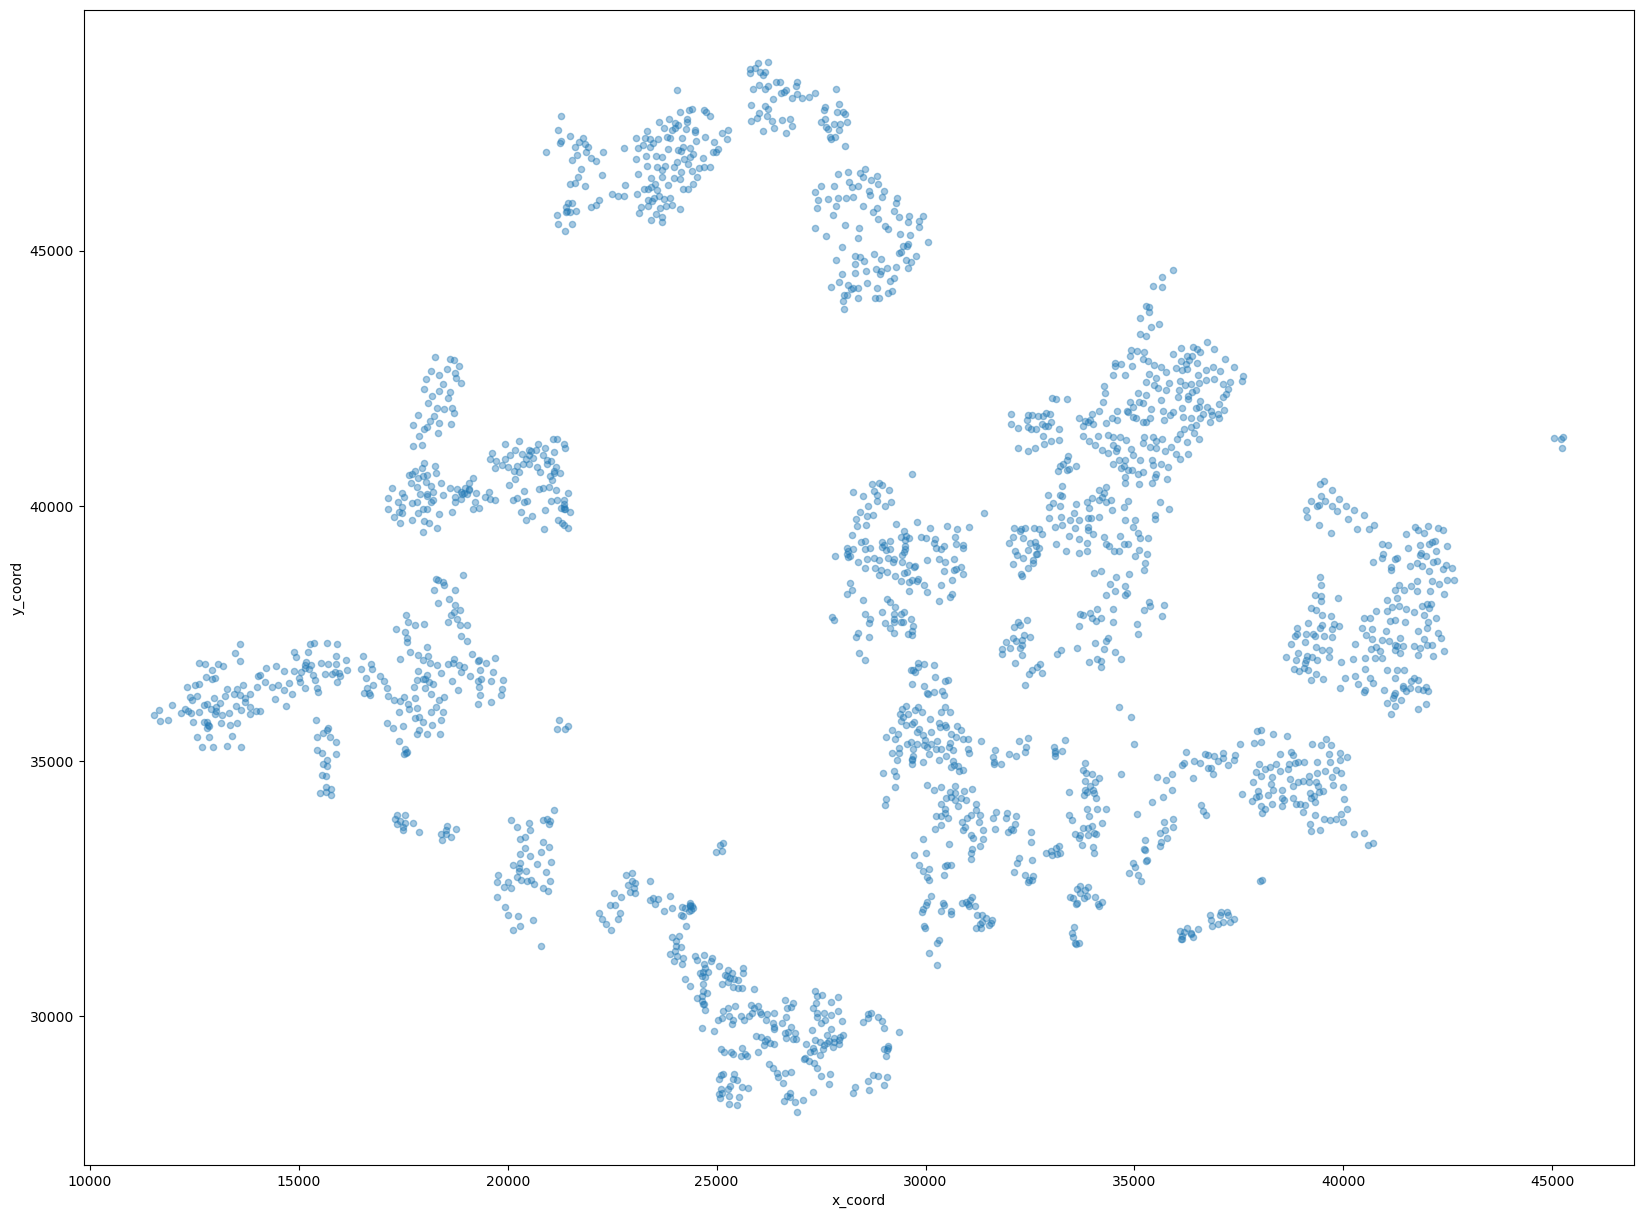

In [11]:
coord_df.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

Seperating the carparks into cluster by using k-means clustering

In [12]:
scaler = StandardScaler()
coord_df[["x_coord_T","y_coord_T"]] = scaler.fit_transform(coord_df[["x_coord","y_coord"]])

In [13]:
kmeans = KMeans(n_clusters=CLUSTER_COUNT,random_state = 1)
kmeans.fit(coord_df[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=50, random_state=1)

In [14]:
coord_df["kmeans"] = kmeans.labels_
coord_df = coord_df[["car_park_no","x_coord","y_coord","kmeans"]]

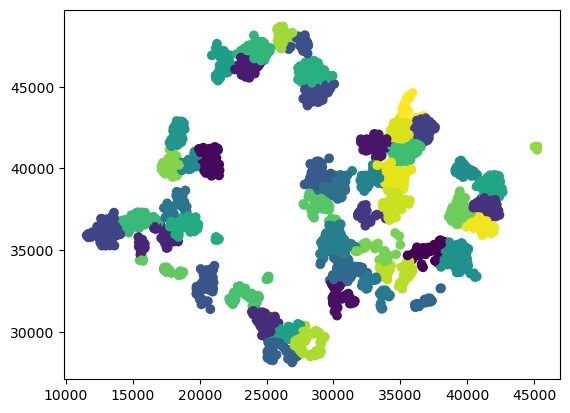

In [15]:
plt.scatter(x=coord_df["x_coord"],y=coord_df["y_coord"],c=coord_df["kmeans"])
plt.show()

In [16]:
coord_df

,car_park_no,x_coord,y_coord,kmeans
0,ACB,30314.7936,31490.4942,2
1,ACM,33758.4143,33695.5198,44
2,AH1,29257.7203,34500.3599,21
3,AK19,28185.4359,39012.6664,14
4,AK31,29482.0290,38684.1754,18
...,...,...,...,...
2177,Y77M,29850.1522,45576.0125,31
2178,Y78M,30057.2209,45166.4820,11
2179,Y8,27772.9219,45686.2734,31
2180,Y82M,29935.5818,45679.7181,31


In [17]:
# convert lat/long to x/y
# Lat/Long of AMK --> 1.369115 / 103.845436
# 4326(WGS84) to 3414(SVY21)

latitude = 1.369115
longitude = 103.845436

site = f'https://developers.onemap.sg/commonapi/convert/4326to3414?latitude={latitude}&longitude={longitude}'
r = requests.get(site)
d = r.text
d = json.loads(d)
xcoord = d.get('X')
ycoord = d.get('Y')
coord = [xcoord, ycoord]

print(xcoord, ycoord)
print(coord)

29348.522650520103 39015.299633351126
[29348.522650520103, 39015.299633351126]


In [18]:
centroids = kmeans.cluster_centers_
rc = scaler.inverse_transform(centroids)
# assuming the centroids are arranged according to their labels..(?)
diff = []
ind = []
i = 0
for c in rc:
    dist = math.sqrt((coord[0]-c[0])**2 + (coord[1]-c[1])**2)
    diff.append(dist)
    ind.append(i)
    i += 1

df_c = pd.DataFrame()
df_c['distance'] = diff
df_c['cluster'] = ind
df_c.sort_values(by='distance', inplace=True)
df_c.head(3)

,distance,cluster
18,713.325611,18
14,762.726571,14
36,1435.336790,36


In [21]:
def closestClusters(latitude, longitude, centroids):
    site = f'https://developers.onemap.sg/commonapi/convert/4326to3414?latitude={latitude}&longitude={longitude}'
    r = requests.get(site)
    d = r.text
    d = json.loads(d)
    xcoord = d.get('X')
    ycoord = d.get('Y')
    coord = [xcoord, ycoord]

    # centroids = kmeans.cluster_centers_
    rc = scaler.inverse_transform(centroids)

    diff = []
    ind = []
    i = 0
    for c in rc:
        dist = math.sqrt((coord[0]-c[0])**2 + (coord[1]-c[1])**2)
        diff.append(dist)
        ind.append(i)
        i += 1

    df_c = pd.DataFrame()
    df_c['distance'] = diff
    df_c['cluster'] = ind
    df_c.sort_values(by='distance', inplace=True)
    print(df_c.head(3))

In [22]:
closestClusters(1.369115, 103.845436, kmeans.cluster_centers_)

       distance  cluster
18   713.325611       18
14   762.726571       14
36  1435.336790       36
